In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Toy problem

A 3D parabola as a toy problem for our neural network to solve 

\begin{equation}
y = x_1^2+x_2^2
\end{equation}


In [2]:
# obtaining data points
x1 = np.arange(-1,1,0.05)
x2 = np.arange(-1,1,0.05)
X1,X2 = np.meshgrid(x1,x2)
Y = X1**2+X2**2

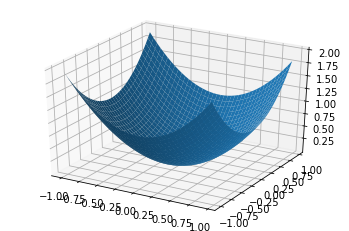

In [3]:
# 3D plot for visualizing function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X1, X2, Y)

#### Regression

We can use this data as is as a regression problem,

In [4]:
# flattening data
x1 = X1.flatten()
x2 = X2.flatten()
y = Y.flatten()

In [5]:
# Setting up the data for processing by DNN
X = np.stack((x1,x2))
Yr = y.reshape(y.shape[0],1).T

#### Binary Classification

We can adapt this into a binary classification problem by thresholding the data,

\begin{equation}
Y_c = 
\begin{cases} 
      0 & y \leq threshold \\
      1 & y > threshold 
\end{cases}
\end{equation}

In [6]:
# thresholding
Yc = Yr.copy()
Yc[abs(Yc)>=0.5] = 1
Yc[abs(Yc)<0.5] = 0

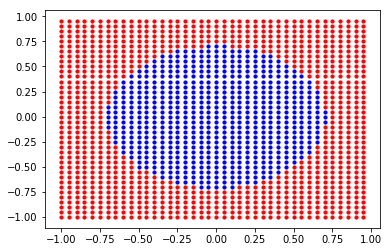

In [7]:
# plotting classes
_x1 = x1.reshape(1,x1.shape[0])
_x2 = x2.reshape(1,x2.shape[0])

c11 = _x1[Yc == 0]
c12 = _x2[Yc == 0]

c21 = _x1[Yc == 1]
c22 = _x2[Yc == 1]

plt.figure()
plt.scatter(c11,c12,c='b',s=10)
plt.scatter(c21,c22,c='r',s=10)

#### Multinomial classification

We can adapt this into a multinomial classification problems by adding additional conditions,

\begin{equation}
Y_m = 
\begin{cases} 
      0, & x_1 \leq 0\ and\ Y_c = 0\\
      1, & x_1 > 0\ and\ Y_c = 0\\
      2, & x_1 \leq 0\ and\ Y_c = 1\\
      3, & x_1 > 0\ and\ Y_c = 1\\ 
\end{cases}
\end{equation}

In [8]:
# thresholding
_Ym = Yc.copy()
_Ym[(_x1 <= 0)*(Yc == 0)] = 0
_Ym[(_x1 > 0)*(Yc == 0)] = 1
_Ym[(_x1 <= 0)*(Yc == 1)] = 2
_Ym[(_x1 > 0)*(Yc == 1)] = 3

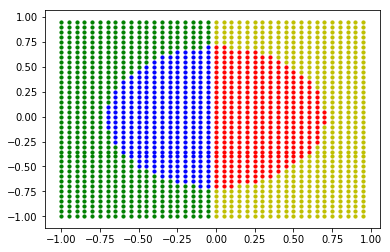

In [9]:
# plotting classes
_x1 = x1.reshape(1,x1.shape[0])
_x2 = x2.reshape(1,x2.shape[0])

c11 = _x1[_Ym == 0]
c12 = _x2[_Ym == 0]

c21 = _x1[_Ym == 1]
c22 = _x2[_Ym == 1]

c31 = _x1[_Ym == 2]
c32 = _x2[_Ym == 2]

c41 = _x1[_Ym == 3]
c42 = _x2[_Ym == 3]

plt.figure()
plt.scatter(c11,c12,c='b',s=10)
plt.scatter(c21,c22,c='r',s=10)
plt.scatter(c31,c32,c='g',s=10)
plt.scatter(c41,c42,c='y',s=10)

In [10]:
# one-hot encoding
def one_hot_encode(y):
    result = (y == 0)*1
    for i in range(1, int(np.max(y)+1)):
        result = np.append(result, (y == i)*1, axis = 0)
    return result

In [11]:
# one-hot encoding for NN
Ym = one_hot_encode(_Ym)

### Vanilla neural network

In [12]:
import numpy as np
from meik.utils.losses import *
from meik.layers import Layer
from meik.metrics import *
from meik.normalizers import Normalizer

class Sequential:
    
    def __init__(self):
        
        self.layers = []
        self.params = {
            'learning_rate': None,
            'epochs': None,
            'loss': None,
        }
        
        self.cost = []
        self.accuracy = []
        
    def add(self,layer):
        
        assert (issubclass(type(layer), Layer))
        
        _id = len(self.layers)
        if _id == 0:
            assert(type(layer.inputs) == int), "Provide number of inputs for initial layer"
            inputs = layer.inputs
        else:
            inputs = self.layers[-1].units
            
        layer.init(_id, inputs)
        self.layers.append(layer)
            
    def build(self, loss = None, normalization = 'none', learning_rate = 0.01, metrics = ['default'], prediction_thresholds = np.array([0.5])):
        
        th = prediction_thresholds
        
        assert(loss in ['mae', 'mse', 'binary_crossentropy', 'categorical_crossentropy']), "Provide loss as either 'mae', 'mse', 'binary_crossentropy or 'categorical_crossentropy' using kwarg 'loss'"
        
        self.params['loss'] = loss
        self.params['learning_rate'] = learning_rate
        self.params['normalization'] = normalization
        
        self.normalize = Normalizer(method = normalization)
        
        if loss == 'mae' or loss == 'mse':

            # This an annoying thing that's here to choose the default metric
            # because there isn't a single default metric for all loss functions
            metrics = (lambda metrics, loss: [loss] if metrics == ['default'] else metrics)(metrics, loss)
            
            # setting up evaluation metrics
            self.metrics = metrics_regression(metrics)
            
            # setting up loss function
            self.loss = (lambda loss: MAE if loss == 'mae' else MSE)(loss)

            # printing
            self.print_text = "Epoch %d/%d - "+loss+": %.4f"
            self.print_params = lambda i, epochs, cost, A, Y: (i+1, epochs, cost)
            
        elif loss == 'binary_crossentropy' or loss == 'categorical_crossentropy':
            
            metrics = (lambda metrics: ['accuracy'] if metrics == ['default'] else metrics)(metrics)
            
            # choosing evaluation metric type
            mbc = metrics_binary_classification(metrics = metrics, prediction_thresholds = th)
            mcc = metrics_categorical_classification(metrics = metrics, prediction_thresholds = th)
            
            # setting up evaluation metrics
            self.metrics = (lambda loss: mbc if loss == 'binary_crossentropy' else mcc)(loss)
            
            # setting up loss function
            self.loss = (lambda loss: binary_crossentropy if loss == 'binary_crossentropy' else categorical_crossentropy)(loss)
            
            # printing
            self.print_text = "Epoch %d/%d - log loss: %.4f - acc: %.4f"
            acc = lambda Y, A: np.sum((A > 0.5) == Y)/Y.size
            self.print_params = lambda i, epochs, cost, A, Y: (i+1, epochs, cost, acc(Y, A))

        # TO DO: proper optimizer objects passed to layer
        for i in range(len(self.layers)):
            self.layers[i].learning_rate = learning_rate
    
    def predict(self,X):
        
        layers = self.layers
        
        A = X
        for i in range(len(layers)):
            A = layers[i].forwardprop(A)
        
        return A

    def backprop(self, Y, A):
        
        layers = self.layers
        
        dZ = A - Y
        dA = self.layers[-1].backprop_output(dZ)
        for i in range(len(layers)-2,-1,-1):
            dA = layers[i].backprop(dA)
            layers[i].update()
            
    def train(self, X, Y, epochs=1, verbose=1):
        
        layers = self.layers
        
        X_norm = self.normalize.train(X)
        
        for i in range(epochs):
            
            A = self.predict(X_norm)
            self.backprop(Y, A)
            
            cost = self.loss(Y, A)
            self.cost.append(cost)
            
            if verbose == 1:
                print(self.print_text % self.print_params(i, epochs, cost, A, Y))
            
        print("------------ Final performance ------------\n")
        print(self.print_text % self.print_params(i, epochs, cost, A, Y))     
        
    def evaluate(self, X, Y):
        
        X = self.normalize.evaluate(X)
            
        A = self.predict(X)
        score = self.metrics.evaluate(Y, A)
        
        self.score = score
        
        return score
        

### Binary Classification NN

In [15]:
from meik.models import Sequential
from meik.layers import Layer
from meik.layers import Dense

In [16]:
model = Sequential()

In [17]:
model.add(Dense(units=32, activation='relu', inputs=2))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [18]:
metrics = ['accuracy', 'binary_crossentropy', 'precision', 'sensitivity', 'specificity', 'confusion_matrix', 'AUC', 'ROC']
th = np.arange(0.0,1.0,0.1)

In [19]:
model.build(loss='binary_crossentropy', normalization='normal', learning_rate=1., metrics = metrics, prediction_thresholds = th)

In [20]:
model.train(X,Yc,epochs=100,verbose=0)

------------ Final performance ------------

Epoch 100/100 - log loss: 0.1326 - acc: 0.9744


In [21]:
cost = model.cost

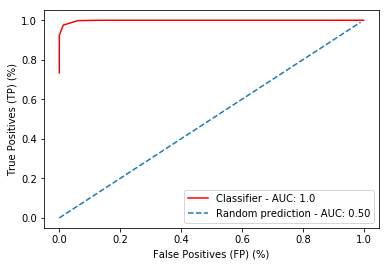

In [22]:
score = model.evaluate(X,Yc)

In [23]:
score

{'accuracy': array([0.60875 , 0.826875, 0.879375, 0.918125, 0.94875 , 0.975   ,
        0.98    , 0.953125, 0.908125, 0.838125]),
 'binary_crossentropy': 0.1318445463376527,
 'precision': array([0.60875   , 0.77857714, 0.83461868, 0.88144796, 0.92234848,
        0.96237624, 0.99164927, 1.        , 1.        , 1.        ]),
 'sensitivity': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99794661, 0.97535934, 0.92299795, 0.84907598, 0.73408624]),
 'specificity': array([0.        , 0.55750799, 0.69169329, 0.79073482, 0.86900958,
        0.93929712, 0.98722045, 1.        , 1.        , 1.        ]),
 'confusion_matrix': array([[[974., 626.],
         [  0.,   0.]],
 
        [[974., 277.],
         [  0., 349.]],
 
        [[974., 193.],
         [  0., 433.]],
 
        [[974., 131.],
         [  0., 495.]],
 
        [[974.,  82.],
         [  0., 544.]],
 
        [[972.,  38.],
         [  2., 588.]],
 
        [[950.,   8.],
         [ 24., 618.]],
 
      

In [ ]:
#A = model.predict(X)
#from meik.metrics import metrics_binary_classification
#ev = metrics_binary_classification(metrics = ['accuracy', 'binary_crossentropy', 'precision', 'sensitivity', 'specificity', 'confusion_matrix', 'AUC', 'ROC'], prediction_thresholds = np.arange(0.0,1.0,0.1))
#a = ev.evaluate(Y,A)

### Multinomial NN

In [ ]:
#from meik.models import Sequential
from meik.layers import Layer
from meik.layers import Dense

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(units=64, activation='relu', inputs=2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

In [ ]:
metrics = ['accuracy', 'binary_crossentropy', 'precision', 'sensitivity', 'specificity', 'confusion_matrix', 'AUC']
th = np.arange(0.0,1.0,0.1)

In [ ]:
model.build(loss='categorical_crossentropy', learning_rate=0.01, metrics = metrics, prediction_thresholds = th)

In [ ]:
model.train(X,Ym,epochs=1000,verbose=0)

In [ ]:
score = model.evaluate(X, Ym)

### Regression NN

In [ ]:
#from meik.models import Sequential
from meik.layers import Layer
from meik.layers import Dense

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(units=64, activation='relu', inputs=2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='linear'))

In [ ]:
model.build(loss='mae', learning_rate=0.01, metrics = ['mae', 'mse', 'rmse', 'r2'])

In [ ]:
model.train(X,Yr,epochs=1000,verbose=0)

In [ ]:
model.evaluate(X, Yr)

In [ ]:
A = model.predict(X)
np.sum((A >= 0.5) == Yc)

In [ ]:
# residual plots?
plt.figure(1)
plt.scatter(Y.T, (Yr.T - A.T))

### Training with Keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=2, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
model.fit(X.T, Yc.T, epochs=500)